# 2. Investigating Momentum

In this section, we empirically investigate some concerns regarding AQR's new momentum product.

Find the data file, `data/momentum_data.xlsx`.

- The first tab contains the momentum factor as an excess return: $\tilde{r}^{\mathrm{mom}}$.
- The second tab contains returns on portfolios corresponding to scored momentum deciles.
  - $r^{\operatorname{mom}(1)}$ denotes the portfolio of stocks in the lowest momentum decile, the "losers" with the lowest past returns.
  - $r^{\operatorname{mom}(10)}$ denotes the portfolio of stocks in the highest momentum decile.
- The third tab gives portfolios sorted by momentum and size.
  - $r^{\text {momsu }}$ denotes the portfolio of small stocks in the top 3 deciles of momentum scores.
  - $r^{\text {momBD }}$ denotes the portfolio of big-stocks in the bottom 3 deciles of momentum scores.

Note that the Fama-French momentum return, $\tilde{r}^{\mathrm{mom}: \mathrm{FF}}$, given in the first tab, is constructed by $\mathrm{FF}$ as,

$$
\tilde{r}^{\mathrm{mom}: \mathrm{FF}}=\frac{1}{2}\left(r^{\mathrm{momBU}}+r^{\mathrm{momSU}}\right)-\frac{1}{2}\left(r^{\mathrm{momBD}}+r^{\mathrm{momSD}}\right)
$$

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [12]:
raw_data = pd.read_excel('momentum_data.xlsx',sheet_name = None)
sheets = list(raw_data.keys())

ff_factors = raw_data[sheets[1]].set_index('Date')
momentum = raw_data[sheets[2]].set_index('Date')
mom_deciles = raw_data[sheets[3]].set_index('Date')
tercile_port = raw_data[sheets[4]].set_index('Date')
rf = raw_data[sheets[5]].set_index('Date')

ff_factors['UMD'] = momentum['UMD']

The Fama-French momentum return

$$\tilde{r}^{mom:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − \frac{1}{2} (\tilde{r}^{momBD} + \tilde{r}^{momSD}) $$

### 2.1 

Is Momentum sill profitable?

The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2024?

Investigate by filling out the summary statistics below for the full-sample and three sub-samples.

#### (a) 
Using the data provided, fill in Table 1 with the appropriate stats for $\tilde{r}^{\text {mom:FF }}$.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 2: Long-only momentum performance. }\\
&\begin{array}{llllll}
\hline \hline \text { Subsample } \quad \text { mean } \quad \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline & & & & \\
1927-2025 & & & \\
1927-1993 & & & \\
1993-2008 & & & \\
2009-2025 & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [13]:
from scipy.stats import skew

ff = ff_factors.copy()

periods = {
    '1927-2025': ('1927-01-01', '2025-12-31'),
    '1927-1993': ('1927-01-01', '1993-12-31'),
    '1993-2008': ('1993-01-01', '2008-12-31'),
    '2009-2025': ('2009-01-01', '2025-12-31')
}

results = []

for label, (start, end) in periods.items():
    sub = ff.loc[start:end].dropna(subset=['UMD'])
    mean = sub['UMD'].mean() * 12
    vol = sub['UMD'].std() * np.sqrt(12)
    sharpe = mean / vol
    skewness = skew(sub['UMD'])
    corr_mkt = sub['UMD'].corr(sub['MKT'])
    corr_val = sub['UMD'].corr(sub['HML'])
    
    results.append([label, mean, vol, sharpe, skewness, corr_mkt, corr_val])

mom_summary = pd.DataFrame(results, columns=[
    'Subsample', 'Mean(ann)', 'Vol(ann)', 'Sharpe', 'Skewness', 'Corr to Mkt', 'Corr to Value'
])

mom_summary.set_index('Subsample', inplace=True)
print(mom_summary.round(3))

           Mean(ann)  Vol(ann)  Sharpe  Skewness  Corr to Mkt  Corr to Value
Subsample                                                                   
1927-2025      0.073     0.162   0.450    -3.059       -0.348         -0.410
1927-1993      0.088     0.161   0.549    -3.904       -0.367         -0.501
1993-2008      0.109     0.172   0.637    -0.626       -0.231         -0.092
2009-2025     -0.014     0.156  -0.090    -2.656       -0.359         -0.325


#### (b) 
Has momentum changed much over time, as seen through these subsample statistics?

<span style="color:green">

Momentum returns have generally been stabl資positive for the sample period before 2008, and the Sharpe Ratio be around 0.45 to 0.64. However, the return has turned negative since 2009, lead to a slightly negative Sharpe Ratio. The correlation between UMD and MKT, and between UMD and HML remain negative through all the subsample, so even when UMD's Sharpe Ratio is negative, it may remain attractive when it comes to forming portfolio. 

</span>

#### (c) 

Does this data support AQR's argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs - would there still be evidence here that momentum is valuable?

<span style="color:green">

Yes. First, momentum strategies have historically delivered significant returns, particularly when AQR launched related products in 2008. Second, and more crucially, momentum has consistently exhibited low correlation with other major market factors such as market and value, enabling it to effectively diversify portfolio risk. Therefore, even when net returns approach zero after accounting for transaction costs, it still adds value to portfolios as a low-correlation diversifier.

</span>

### 2.2. 

Whether a long-only implementation of momentum is valuable.

Construct your own long-only implementation:

$$\tilde{r}^{momU:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − r^f $$

Note that this is following the FF approach of treating big and small stocks separately. This would be very similar to a scaled version of,

$$\tilde{r}^{momU} = \frac{1}{3} (\tilde{r}^{mom(8)} + \tilde{r}^{mom(9)} + \tilde{r}^{mom(10)}) − r^f $$

For the question below, use the FF-style $\tilde{r}^{momU:FF}_t$

#### (a) 

Fill out Table 2 for the data in the period 1994-2024.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 2: Long-only momentum performance. }\\
&\begin{array}{llllll}
\hline \hline \text { 1994-2025} & \text { mean } \quad \text { vol } & \text { Sharpe } & \text { skew } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline \text { Long-and-short, }\left(\tilde{r}^{\text {mom:FF }}\right) & & & \\
\text { Long-only }\left(\tilde{r}^{\text {momU:FF }}\right) & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [14]:

start, end = '1994-01-01', '2025-12-31'

momU_FF = (tercile_port['BIG HiPRIOR'] + tercile_port['SMALL HiPRIOR'])/2 - rf['RF']

ff_sub = ff_factors.loc[start:end].copy()
momU_FF_sub = momU_FF.loc[start:end].dropna()

mean_ls = ff_sub['UMD'].loc[start:end].mean() * 12
vol_ls = ff_sub['UMD'].loc[start:end].std() * np.sqrt(12)
sharpe_ls = mean_ls / vol_ls
skew_ls = skew(ff_sub['UMD'].loc[start:end])
corr_mkt_ls = ff_sub['UMD'].loc[start:end].corr(ff_sub['MKT'])
corr_val_ls = ff_sub['UMD'].loc[start:end].corr(ff_sub['HML'])

mean_lo = momU_FF_sub.mean() * 12
vol_lo = momU_FF_sub.std() * np.sqrt(12)
sharpe_lo = mean_lo / vol_lo
skew_lo = skew(momU_FF_sub)
corr_mkt_lo = momU_FF_sub.corr(ff_sub['MKT'].loc[start:end])
corr_val_lo = momU_FF_sub.corr(ff_sub['HML'].loc[start:end])

table2 = pd.DataFrame({
    'Mean(ann)': [mean_ls, mean_lo],
    'Vol(ann)': [vol_ls, vol_lo],
    'Sharpe': [sharpe_ls, sharpe_lo],
    'Skewness': [skew_ls, skew_lo],
    'Corr to Mkt': [corr_mkt_ls, corr_mkt_lo],
    'Corr to Value': [corr_val_ls, corr_val_lo]
}, index=['Long-short (UMD)', 'Long-only (momU_FF)'])

print(table2.round(3))

                     Mean(ann)  Vol(ann)  Sharpe  Skewness  Corr to Mkt  \
Long-short (UMD)         0.041     0.166   0.249    -1.446       -0.306   
Long-only (momU_FF)      0.115     0.178   0.645    -0.444        0.905   

                     Corr to Value  
Long-short (UMD)            -0.215  
Long-only (momU_FF)         -0.124  


#### (b)  

Is long-only momentum as attractive as long-short momentum with respect to mean, volatil-ity, and Sharpe Ratio?

<span style="color:green">

According to the data, pure long-only momentum strategies are more attractive than long-short strategies. They deliver higher average returns with comparable volatility, resulting in superior Sharpe ratios.

</span>

#### (c) 

Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?

<span style="color:green">

No. Pure long-only momentum strategies exhibit a correlation with the market as high as 93.6%, making them almost entirely susceptible to market risk. In contrast, long-short momentum strategies show a negative correlation with the market. Therefore, pure long-only strategies do not provide risk diversification benefits.

</span>

#### (d) 

Show a plot of the cumulative product of $1+\tilde{r}^{\text {mom:FF }}$ and $1+\tilde{r}^{\text {momU:FF }}$ over the 1994-2024 subsample. $^2$

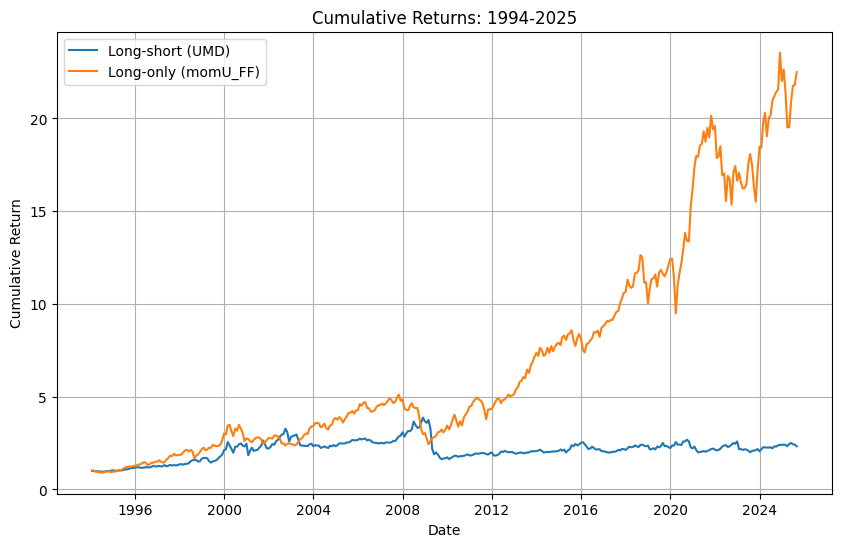

In [15]:
cum_UMD = (1 + ff_sub['UMD'].loc[start:end]).cumprod()
cum_momU = (1 + momU_FF_sub).cumprod()

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(cum_UMD, label='Long-short (UMD)')
plt.plot(cum_momU, label='Long-only (momU_FF)')
plt.title('Cumulative Returns: 1994-2025')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

### 2.3. Is momentum just data mining, or is it a robust strategy?

Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:

- long the top 1 decile and short the bottom 1 deciles:

$$ \tilde{r}^{momD1} = r^{mom(10)} - r^{mom(1)}$$

- long the top 3 deciles and short the bottom 3 deciles:

$$ 
\begin{aligned}
\tilde{r}^{momD3} &= \frac{1}{3}(r^{mom(8)} + r^{mom(9)} + r^{mom(10)}) - \frac{1}{3} (r^{mom(3)} + r^{mom(2)} + r^{mom(1)})\\
&= \frac{1}{3}\sum_{k = 8}^{10} r^{mom(k)} - \frac{1}{3}\sum_{k = 1}^{3} r^{mom(k)} 
\end{aligned}$$

- long the top 5 deciles and short the bottom 5 decile:

$$ \tilde{r}^{momD5} = \frac{1}{5}\sum_{k = 6}^{10} r^{mom(k)} - \frac{1}{5}\sum_{k = 1}^{5} r^{mom(k)} $$

#### (a) 

Compare all three constructions, (in the full-sample period,) by filling out the stats in the table below for the period 1994-2025.

$$
\begin{equation}
\begin{aligned}
&\text { Table 3: Robustness of momentum construction. }\\
&\begin{array}{lllllll}
\hline \hline \text { 1994-2025 } \quad \text { mean } & \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline \tilde{r}^{\text {momD1 }} & & & & & \\
\tilde{r}^{\text {momD3 }} & & & & \\
\tilde{r}^{\text {momD5 }} & & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation}
$$

In [16]:
momD1 = mom_deciles['Hi PRIOR'] - mom_deciles['Lo PRIOR']
momD3 = mom_deciles.iloc[:,-3:].mean(axis = 1) - mom_deciles.iloc[:,:3].mean(axis = 1)
momD5 = mom_deciles.iloc[:,-5:].mean(axis = 1) - mom_deciles.iloc[:,:5].mean(axis = 1)

ff_sub = ff_factors.loc['1994-01-01':]
momD1_sub = momD1.loc['1994-01-01':]
momD3_sub = momD3.loc['1994-01-01':]
momD5_sub = momD5.loc['1994-01-01':]

def compute_stats(series, benchmark1, benchmark2):
    mean = series.mean() * 12
    vol = series.std() * np.sqrt(12)
    sharpe = mean / vol
    skewness = skew(series)
    corr1 = series.corr(benchmark1)
    corr2 = series.corr(benchmark2)
    return [mean, vol, sharpe, skewness, corr1, corr2]

results = {
    'momD1': compute_stats(momD1_sub, ff_sub['MKT'], ff_sub['HML']),
    'momD3': compute_stats(momD3_sub, ff_sub['MKT'], ff_sub['HML']),
    'momD5': compute_stats(momD5_sub, ff_sub['MKT'], ff_sub['HML'])
}

table3 = pd.DataFrame(results, index=['Mean(ann)','Vol(ann)','Sharpe','Skewness','Corr to Mkt','Corr to Value']).T
print(table3.round(3))

       Mean(ann)  Vol(ann)  Sharpe  Skewness  Corr to Mkt  Corr to Value
momD1      0.074     0.299   0.248    -1.266       -0.320         -0.246
momD3      0.027     0.193   0.139    -1.314       -0.354         -0.221
momD5      0.016     0.134   0.116    -1.402       -0.349         -0.214


#### (b) 

Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

<span style="color:green">

Yes. The more assets be constructed in the factor, the smaller mean the factor has, and the lower the volatility the factoe has. The former is because the less average momentom the assets have, and the latter is because the diversify effect.

</span>

#### (c) 

Should AQR's retail product consider using a 1-decile or 5-decile construction?

<span style="color:green">

1-decile construction, because it delivers a higher Sharpe ratio.

</span>

#### (d) 

Does $\tilde{r}^{\text {momD3 }}$ have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

<span style="color:green">

Yes, but the momentum factor in the Fama-French three-factor model performs better, yielding higher returns with lower volatility and consequently a higher Sharpe ratio. This is primarily because the Fama-French approach achieves better diversified effect by distinguishing between large-cap and small-cap stocks, whereas ordinary tertile construction may suffer from market capitalization bias.

</span>

### 2.4. Does implementing momentum require trading lots of small stocks-- thus causing even larger trading costs?

For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)

Use the data provided on both small-stock “winners”, $r^{momSU}$, and small-stock “losers”, $r^{momSD}$, to construct a small-stock momentum portfolio,

$$ r^{momS}_t = r^{momSU}_t - r^{momSD}_t $$

Similarly, use the data provided to construct a big-stock momentum portfolio,

$$ r^{momB}_t = r^{momBU}_t − r^{momBD}_t $$

#### (a) 

Fill out Table 4 over the sample 1994-2025.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 4: Momentum of small and big stocks. }\\
&\begin{array}{llllll}
\hline \hline \text { 1994-2025 } & \text { mean } & \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}[m] \\
\hline \hline \text { All stocks, } \tilde{r}^{\text {mom:FF }} & & & & \\
\text { Small stocks } r_t^{\text {mom } S} & & & \\
\text { Large stocks } r_t^{\text {mom } B} & & & \\
\hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import skew

momS = tercile_port['SMALL HiPRIOR'] - tercile_port['SMALL LoPRIOR']
momB = tercile_port['BIG HiPRIOR'] - tercile_port['BIG LoPRIOR']

ff_sub = ff_factors.loc['1994-01-01':]
momS_sub = momS.loc['1994-01-01':]
momB_sub = momB.loc['1994-01-01':]

def compute_stats(series, benchmark):
    mean = series.mean() * 12
    vol = series.std() * np.sqrt(12)
    sharpe = mean / vol
    skewness = skew(series)
    corr = series.corr(benchmark)
    return [mean, vol, sharpe, skewness, corr]

results = {
    'All stocks (UMD)': compute_stats(ff_sub['UMD'], ff_sub['MKT']),
    'Small stocks (momS)': compute_stats(momS_sub, ff_sub['MKT']),
    'Large stocks (momB)': compute_stats(momB_sub, ff_sub['MKT'])
}

table4 = pd.DataFrame(results, index=['Mean(ann)','Vol(ann)','Sharpe','Skewness','Corr to MKT']).T
print(table4.round(3))

                     Mean(ann)  Vol(ann)  Sharpe  Skewness  Corr to MKT
All stocks (UMD)         0.041     0.166   0.249    -1.446       -0.306
Small stocks (momS)      0.062     0.168   0.369    -1.806       -0.309
Large stocks (momB)      0.021     0.182   0.114    -0.852       -0.273


#### (b) 

Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

<span style="color:green">

Not entirely. While momentum strategies for small-cap stocks do indeed outperform, with Sharpe ratios significantly higher than those for large-cap stocks, large-cap momentum strategies alone can still generate stable excess returns. Therefore, the appeal of momentum strategies is not solely driven by small-cap stocks.

</span>

### 2.5.

In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?

<span style="color:green">

Overall, AQR's retail products exhibit certain design shortcomings. Its pure long-only strategy results in high market correlation, diminishing its value as a diversification tool. Furthermore, the quarterly rebalancing frequency may cause the strategy to deviate from the classic Fama-French momentum factor. Suggested improvements include: introducing short positions to reduce market correlation and considering increasing rebalancing frequency to more closely track the momentum factor.

</span>